# Train AI to play Game

## Team 03
|Name|SRN|
|----|---|
|Arunvenkat C A|PES2UG20CS068|
|Ashutosh Routray|PES2UG20CS072|
|C V Eswar Sai Reddy|PES2UG20CS096|

### We are using Reinforcement learning to train an agent to play a game. 
### The game environments are taken from OpenAI Gym. 

The game environments are of two types, **Discrete** and **Continous**. 

Discrete environments will have Fixed set of input. 
Ex: A person walking on a path can *move forward*, *stay still* or *move backward* (may sound weird but why not)

Continous environments will have single attribute, which has a low and high points of input. 
Ex: A person driving a car can drive the car at any speed in the range of 0 to max speed supported by the car and the environment. In this case the value of speed has infinite options.

Few environments can be both **Discrete and Continuous** too.

Importing the necessary modules

In [1]:
import numpy as np
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt
import time, math, random, gym, warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# For clearing the output to view the environment's progress 
# clearly in case of terminal-based rendering
from IPython.display import clear_output 


## 1. Discrete environment - Different states

In [2]:
# this code block is to create a new gym environment of frozen lake with non-slippery environment
# default one consists of slippery environment.
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

For the model to be able to work with both discrete and continous environment we'll check if the model is discrete or continous and change the steps in the code accordingly.

Initializing Game Environment

In [3]:
game_name = "FrozenLakeNoSlip-v0"
env = gym.make(game_name, desc = generate_random_map(6)) # Creating game environment
env.reset() # resetting the game environment
env.render() 
env.reset()


SFHFFF
FFHFHF
FFFFFF
HHFFFF
FFFFFF
FFFHFG


0

Making **Agent** Class to simplify the model operations

In [4]:
class Agent:
    def __init__(self, env):
        # environment is taken as argument to the class
        # Checking if the environment is discrete or continous
        self.is_env_discrete = True if type(env.action_space) == gym.spaces.discrete.Discrete else False

        # if discrete initialize action space. 
        if self.is_env_discrete:
            self.action_size = env.action_space.n
            print(f"The environment is Discrete and has Action Space {self.action_size}")
        # if continous initialize action range and shape
        else:
            self.action_low, self.action_high, self.action_shape = env.action_space.low, self.action_space.high, self.action_space.shape
            print(f"The environment is Continous and has Action Range {self.action_low} to {self.action_high} with shape {self.action_shape}")
    
    def get_action(self, state):
        # function to get the action to perform. 
        if self.is_env_discrete:
            # if the environment is discrete a value among the values in discrete state is considered.
            action = random.choice(range(self.action_size))  
        else: # if environment is continous (since there are only two possible types of environment)
            # if the environment is continous a value among the value range is selected.
            action = np.random.uniform(self.action_low, self.action_high, self.action_shape)
        return action
            
    

A basic agent which can control both Discrete and continous games is created above.
### Implementing Q-Learning Algorithm to develop an agent which learns based on state and reward

In [5]:
# making a class for Q-Learning agent
class Q_Agent:
    # __init__() --> Borrowed from class: Agent which is created before
    def __init__(self, env, discount_rate=0.97, learning_rate=0.1):
        # environment is taken as argument to the class
        # Checking if the environment is discrete or continous
        self.is_env_discrete = True if type(env.action_space) == gym.spaces.discrete.Discrete else False

        # if discrete initialize action space. 
        if self.is_env_discrete:
            self.action_size = env.action_space.n
            try:
                self.state_size = env.observation_space.n
            except:
                print("Falied to get state size:", env.observation_space)
            print(f"The environment is Discrete and has Action Space {self.action_size}")

        # if continous initialize action range and shape 
        else:
            print(f"The environment is Discrete and has Action Space {self.action_size} and State size {self.state_size}")
            self.action_low, self.action_high, self.action_shape = env.action_space.low, self.action_space.high, self.action_space.shape
            print(f"The environment is Continous and has Action Range {self.action_low} to {self.action_high} with shape {self.action_shape}")

        self.state_size = env.observation_space.n
        # self.state_size = 4
        print("State size:", self.state_size)
        
        self.eps = 1.0
        # discount rate and learning rate are obtained and stored for using for performing calculations
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        # initlalizing Q-Table
        self.build_model()
    
    def build_model(self):
        self.q_table = 0.0001 * np.random.random([self.state_size, self.action_size])
    
    def get_random_action(self, state):
        # function to get the action to perform. 
        if self.is_env_discrete:
            # if the environment is discrete a value among the values in discrete state is considered.
            action = random.choice(range(self.action_size))  
        else: # if environment is continous (since there are only two possible types of environment)
            # if the environment is continous a value among the value range is selected.
            action = np.random.uniform(self.action_low, self.action_high, self.action_shape)
        return action

    def get_action(self, state):
        q_state = self.q_table[state]
        action_greedy = np.argmax(q_state)
        action_random = self.get_random_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        # this function updates the Q-Table after performing a step in the model based on the response obtained from the model. 
        state, action, next_state, reward, done = experience
        # if the state is terminal state the array will be initialized with zeros.
        # if the state is not terminal state the q_next value will be obtained from table
        q_next = np.zeros([self.action_size]) if done else self.q_table[next_state]
        q_target = reward + self.discount_rate * np.max(q_next)
        
        q_update = q_target - self.q_table[state,action]
        self.q_table[state,action] += self.learning_rate * q_update
        
        if done:
            self.eps = self.eps * 0.99
        

In [6]:
agent = Q_Agent(env)

The environment is Discrete and has Action Space 4
State size: 36


In [7]:
total_reward = 0
episode_count = 0
ep_base = 0
rewards = []
epsilons = []

In [8]:

for ep in range(300):
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train((state,action,next_state,reward,done))
        state = next_state
        total_reward += reward
    if ep % 1 == 0:
        print("s:", state, "a:", action)
        
        print("Episode: {}, Total reward: {}, eps: {}".format(ep_base,total_reward,agent.eps))
        env.render()
        # print(agent.q_table)
        time.sleep(0.1)
        clear_output(wait=True)
    ep_base += 1
    rewards.append(total_reward)
    epsilons.append(agent.eps)
    if ep % 1 == 0:
        clear_output(wait = True)

s: 35 a: 1
Episode: 299, Total reward: 109.0, eps: 0.04904089407128576
  (Down)
SFHFFF
FFHFHF
FFFFFF
HHFFFF
FFFFFF
FFFHFG


In [9]:
env.close()

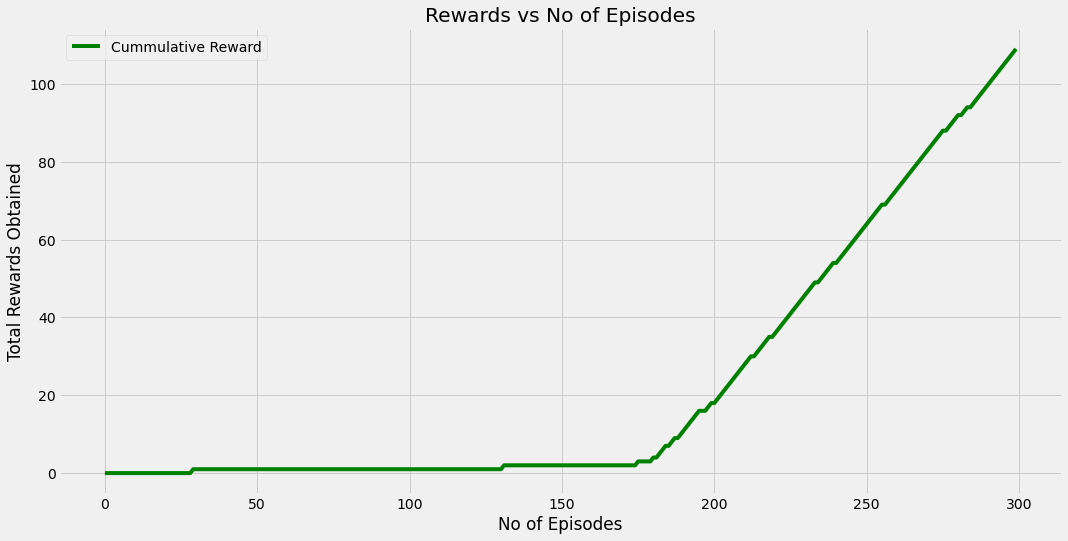

In [10]:
plt.figure(figsize=(16,8))
plt.title('Rewards vs No of Episodes')
plt.xlabel('No of Episodes')
plt.ylabel('Total Rewards Obtained')
plt.plot(rewards, color = 'green', label = 'Cummulative Reward')
plt.legend()

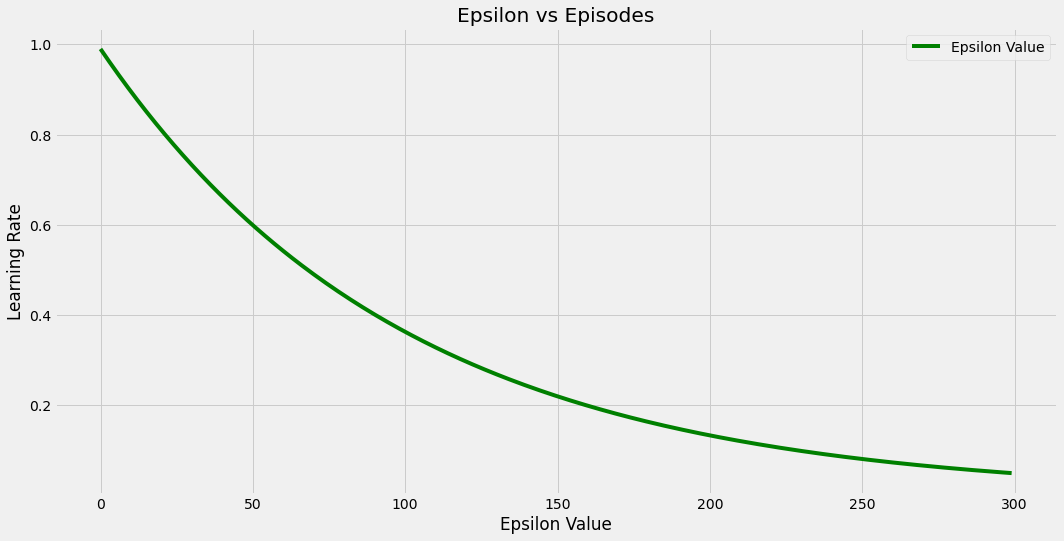

In [11]:
plt.figure(figsize=(16,8))
plt.title('Epsilon vs Episodes')
plt.xlabel('Epsilon Value')
plt.ylabel('Learning Rate')
plt.plot(epsilons, color = 'green', label = 'Epsilon Value')
plt.legend()

In [12]:
print("Final Q-Table:")
print("State\tAction 1\t\tAction 2\t\tAction 3\t\tAction 4")
for line in range(len(agent.q_table)):
    print(f"{line}\t" + "\t".join([str(num) for num in agent.q_table[line]]))
print()
env.render()
env.close()

Final Q-Table:
State	Action 1		Action 2		Action 3		Action 4
0	0.010567197643655036	0.49963154521528846	4.516658437368598e-05	0.010579037228768408
1	4.573914464119962e-05	0.04432283418425029	5.626044118781783e-06	4.5662669985840384e-05
2	4.093179533370023e-05	3.097806789114141e-05	7.609911916354007e-06	5.521908150882099e-05
3	5.364476534991388e-05	9.225777147028314e-06	7.038434596497148e-05	4.673643036979004e-05
4	4.208038233855414e-05	9.280532893542377e-05	7.785521978568334e-06	9.255945927964722e-05
5	7.1461590398439e-05	2.1483916821119123e-05	5.5693488119342285e-05	6.532811271448297e-05
6	4.5859184935322626e-05	0.005696589933698346	0.5981986158958525	4.5945965020450595e-05
7	0.0012214826822522984	0.6865747404808352	5.24141911825808e-07	0.0013281492022925844
8	7.500068969683937e-05	6.541739663434427e-05	2.6289790620816857e-05	3.2273524036642585e-05
9	6.121604725417519e-05	6.221742511012736e-05	4.7794808269265154e-05	6.060413623772945e-05
10	8.756169354539134e-06	1.3368969725763481e-05	